In [32]:
import caffe
import csv
import os
import sys
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time


model_def = 'models/bvlc_reference_caffenet_utkin/deploy_siam.prototxt'
model_weights = 'models/bvlc_reference_caffenet_utkin/oldStates/caffenet_utkin_train_iter_40000.caffemodel'
data_file = 'micro_data.txt'

folder = 'searchProblem/'
pattern_micro = 636
pattern_name = ''
pattern_feat = []

net = 0
images_list = []
images_dict = {}

def read_segments(filename=None):
    global images_list, images_dict, pattern_name
    with open(filename, 'rb') as file:
        for row in file:
            try:
                name, microsegment = row.split()
            except ValueError as e:
                print row
            images_dict[name] = int(microsegment)
            images_list.append(name)
            if int(microsegment) == pattern_micro:
                pattern_name = name
                
read_segments(filename=data_file)

# initializing net
caffe.set_device(0)
caffe.set_mode_gpu()
net = caffe.Net(model_def, model_weights, caffe.TEST)

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]
        
flatten = lambda l: [item for sublist in l for item in sublist]        

# feature extraction
start = time.time()
y, names = [], []
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_raw_scale('data', 255)
net.blobs['data'].reshape(100, 1, 227, 227)
num = 0
for images in chunks(images_list, 100):
    images_data = [folder + str(i) for i in images] 
    net.blobs['data'].data[...] = map(lambda x: 
                                      np.transpose(transformer.preprocess('data',
                                                                          caffe.io.load_image(x, color=False)),
                                                   (2, 0, 1)), images_data)
    out = net.forward()
    num += 1
    y.append(net.blobs['feat'].data[...].copy())
    names.append(images_data)
    print num
end = time.time()
print(end - start)

features = flatten(y)
car_name = flatten(names)

def transform(features):
    model = PCA(n_components=3, random_state=0)
    return model.fit_transform(features)

feats = transform(features)

def get_feature(pattern_name, names, feats):
    index = names.index(folder + pattern_name)
    return feats[index]

pattern_feat = get_feature(pattern_name, car_name, feats)

In [92]:
def distance(feat1, feat2):
    return np.sqrt(np.sum(np.square(feat1 - feat2)))

def get_distances(pattern, names, features):
    dists = []
    for car, feature in zip(names, features):
        dists.append([car, distance(feature, pattern_feat)])
    dists = sorted(dists, key=lambda x: x[1])
    return dists

distances = get_distances(pattern_feat, car_name, feats)

In [93]:
distances

[['searchProblem/22bf5d68-9c3f-76c4-cb34-a904ef9f9ed1.jpg', 0.0],
 ['searchProblem/6da98880-c52b-a007-e340-5186ea19832b.jpg', 0.0],
 ['searchProblem/41d459f0-573c-fc86-3d93-eca350fa6886.jpg', 0.0],
 ['searchProblem/f97eaff0-7dc3-8c31-c5a7-be53b00a94a8.jpg', 0.0],
 ['searchProblem/88b271cf-a68d-3de5-6438-7117fd74bef4.jpg', 0.0],
 ['searchProblem/882f6362-a593-7281-a6fb-815a5e9c729e.jpg', 0.0],
 ['searchProblem/8abd5f2a-8637-cfd0-504c-81d4d72f73e9.jpg', 0.0],
 ['searchProblem/c6924912-885d-1a10-b864-9a23ffc4a89f.jpg', 0.0],
 ['searchProblem/9f048b90-839f-2eb7-40d8-f9aad4e289cb.jpg', 0.0],
 ['searchProblem/2237df84-2c21-39ac-dc0c-e50502af4034.jpg', 0.0],
 ['searchProblem/0f092dba-860f-c106-b975-e36026458e34.jpg', 0.0],
 ['searchProblem/02846f4c-9b59-34dc-0945-e8312d9af40d.jpg', 0.0],
 ['searchProblem/73c87fa1-fd08-0c8c-f1c5-c4195b4131e1.jpg', 0.0],
 ['searchProblem/67a071fe-8ba6-84b0-4a0b-f73b71b87114.jpg', 0.0],
 ['searchProblem/0e2bf4a0-e0a5-e832-af49-873f874bc96f.jpg', 0.0],
 ['searchP

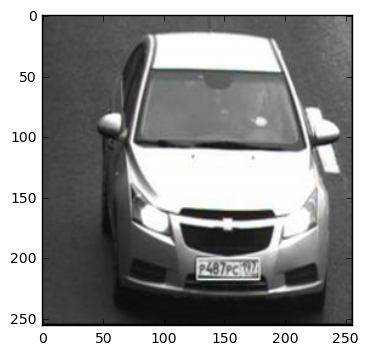

In [99]:
 import matplotlib.image as mpimg
img=mpimg.imread(folder+pattern_name)
plt.imshow(img)
plt.show()

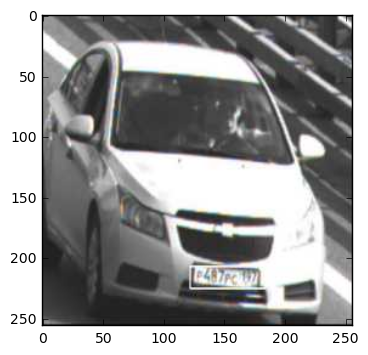

In [101]:
img=mpimg.imread('searchProblem/22bf5d68-9c3f-76c4-cb34-a904ef9f9ed1.jpg')
plt.imshow(img)
plt.show()

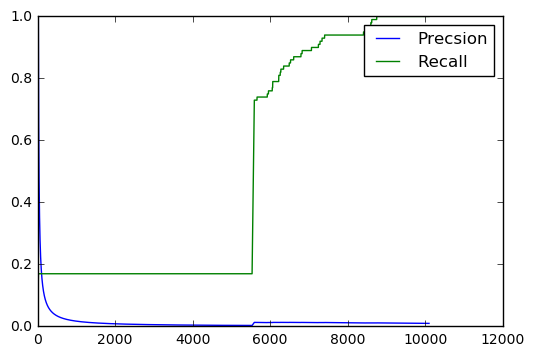

In [124]:
def get_microsegment(pattern):
    return images_dict[pattern.split('/')[-1]]


def match(cars, microsegment, n):
    counter = 0
    for car in cars[:n]:
        if get_microsegment(car[0]) == microsegment:
            counter += 1
    pr = float(counter) / n
    rr = float(counter)/ 100
    #fm = 2 * pr * rr / pr + rr
    return pr, rr

prs = []
rrs = []
nfe = []
for number_fetched_elements in range(1, 10100):
    pr, rr = match(distances, pattern_micro, number_fetched_elements)
    prs.append(pr)
    rrs.append(rr)
    nfe.append(number_fetched_elements)
plt.plot(nfe, prs)
plt.plot(nfe, rrs)
plt.legend(['Precsion', 'Recall'], loc='upper right')
plt.show()